In [1]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv",
                   na_values=["9999", "", " ", "Presented but no response", "NA"])

/tmp/ipykernel_52/3398236917.py:2: DtypeWarning: Columns (129,408,630,671,689,978,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1263,1266,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1439,1442,1463,1546,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv",


In [2]:
data['WELLNESS_self_rated_mental_health'].value_counts()

WELLNESS_self_rated_mental_health
Good         2785
Very good    2442
Fair         2048
Excellent    1057
Poor          931
Name: count, dtype: int64

In [4]:
data['WELLNESS_malach_pines_burnout_measure_score'].describe()

count    4465.000000
mean        3.438746
std         1.159330
min         1.000000
25%         2.700000
50%         3.500000
75%         4.100000
max         7.000000
Name: WELLNESS_malach_pines_burnout_measure_score, dtype: float64

In [5]:
import numpy as np
from scipy import stats

# Set a random seed for reproducibility
np.random.seed(42)

# Parameters for the bootstrapping
so_many_bootstrapped_confidence_intervals = 1000  # Number of samples
confidence_level = 95  # Confidence level for the interval

# Extracting happiness scores for Poor Mental Health and not engaged
poor_burnout_score = data[data['WELLNESS_self_rated_mental_health'] == "Poor"]['WELLNESS_malach_pines_burnout_measure_score']
good_burnout_score = data[data['WELLNESS_self_rated_mental_health'] != "Poor"]['WELLNESS_malach_pines_burnout_measure_score']

# Function to perform bootstrapping
def bootstrap_ci(data, num_iterations=so_many_bootstrapped_confidence_intervals, n_samples=None):
    if n_samples is None:
        n_samples = len(data)  # Use the actual number of samples

    simulated_bootstrap_statistics = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        bootstrap_sample = np.random.choice(data.dropna(), size=n_samples, replace=True)
        simulated_bootstrap_statistics[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    confidence_interval = np.percentile(simulated_bootstrap_statistics, 
                                        [(100 - confidence_level) / 2, 
                                         confidence_level + ((100 - confidence_level) / 2)])
    
    return np.mean(data), confidence_interval, simulated_bootstrap_statistics

# Bootstrapping confidence intervals for poor engagement
mean_poor, ci_poor, poor_bootstrap_samples = bootstrap_ci(poor_burnout_score)
# Bootstrapping confidence intervals for Good Mental Health
mean_good, ci_good, good_bootstrap_samples = bootstrap_ci(good_burnout_score)

print(f"Mean Burnout Score (Poor Mental Health): {mean_poor}")
print(f"95% Confidence Interval (Poor Mental Health): {ci_poor}")
print(f"Mean Happiness Score (Good Mental Health): {mean_good}")
print(f"95% Confidence Interval (Good Mental Health): {ci_good}")

Mean Burnout Score (Poor Mental Health): 5.06923076923077
95% Confidence Interval (Poor Mental Health): [4.99955424 5.13566327]
Mean Happiness Score (Good Mental Health): 3.3052095953477103
95% Confidence Interval (Good Mental Health): [3.28612452 3.32635786]


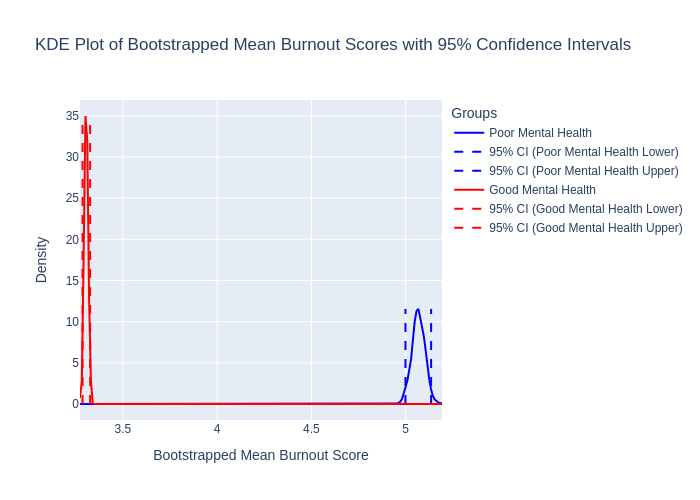

In [7]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

# KDEs for Poor and Good Mental Health burnout scores
kde_poor = stats.gaussian_kde(poor_bootstrap_samples)
kde_good = stats.gaussian_kde(good_bootstrap_samples)

# Range for KDE plots
x_values = np.linspace(min(min(poor_bootstrap_samples), min(good_bootstrap_samples)),
                       max(max(poor_bootstrap_samples), max(good_bootstrap_samples)), 200)

# Create the plot
fig = go.Figure()

# KDE for Poor Mental Health
fig.add_trace(go.Scatter(x=x_values, y=kde_poor(x_values), mode='lines',
                         name='Poor Mental Health', line=dict(color='blue')))

# Vertical dashed lines for Poor Mental Health CI
fig.add_trace(go.Scatter(x=[ci_poor[0], ci_poor[0]], y=[0, max(kde_poor(x_values))],
                         mode='lines', line=dict(color='blue', dash='dash'),
                         name="95% CI (Poor Mental Health Lower)"))

fig.add_trace(go.Scatter(x=[ci_poor[1], ci_poor[1]], y=[0, max(kde_poor(x_values))],
                         mode='lines', line=dict(color='blue', dash='dash'),
                         name="95% CI (Poor Mental Health Upper)"))

# KDE for Good Mental Health
fig.add_trace(go.Scatter(x=x_values, y=kde_good(x_values), mode='lines',
                         name='Good Mental Health', line=dict(color='red')))

# Vertical dashed lines for Good Mental Health CI
fig.add_trace(go.Scatter(x=[ci_good[0], ci_good[0]], y=[0, max(kde_good(x_values))],
                         mode='lines', line=dict(color='red', dash='dash'),
                         name="95% CI (Good Mental Health Lower)"))

fig.add_trace(go.Scatter(x=[ci_good[1], ci_good[1]], y=[0, max(kde_good(x_values))],
                         mode='lines', line=dict(color='red', dash='dash'),
                         name="95% CI (Good Mental Health Upper)"))

# Layout adjustments
fig.update_layout(
    title="KDE Plot of Bootstrapped Mean Burnout Scores with 95% Confidence Intervals",
    xaxis_title="Bootstrapped Mean Burnout Score",
    yaxis_title="Density",
    legend_title="Groups"
)

fig.show(renderer="png")
